<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read thru the documentation to accomplish this task. 

`Tip:` You will need to install the `bs4` library inside your conda environment. 

In [2]:
from bs4 import BeautifulSoup
import requests

In [4]:
data = pd.read_csv('data/job_listings.csv')
data.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [7]:
data['description'] = [BeautifulSoup(text, 'html').get_text() for text in data ['description']]

In [8]:
indeed = data.copy()
indeed.head()

,Unnamed: 0,description,title,descrription
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist,"b""Job Requirements:\nConceptual understanding ..."
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo..."
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen..."
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...


In [ ]:
## 2) Use Spacy to tokenize the listings 

In [9]:
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [10]:
tokens = []

for doc in tokenizer.pipe(indeed['description'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

indeed['tokens'] = tokens

In [11]:
indeed.head()

,Unnamed: 0,description,title,descrription,tokens
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist,"b""Job Requirements:\nConceptual understanding ...","[b""job, requirements:\nconceptual, understandi..."
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo...","[b'job, description\n\nas, data, scientist, 1,..."
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...,"[b'as, data, scientist, working, consulting, b..."
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen...","[b'$4,969, $6,756, monthcontractunder, general..."
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...,"[b'location:, usa, \xe2\x80\x93, multiple, loc..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [13]:
##### Your Code Here #####
vect = CountVectorizer(stop_words='english')


vect.fit(data["description"])


dtm = vect.transform(indeed["description"])

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

dtm.head()

,00,000,02115,03,0356,04,062,06366,08,10,...,zenreach,zero,zeus,zf,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [14]:

from collections import Counter
import squarify
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

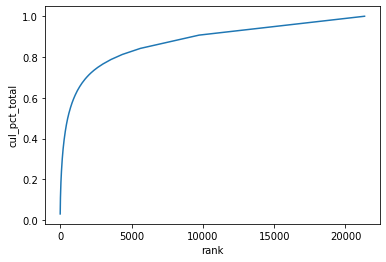

In [22]:
import seaborn as sns


sns.lineplot(x='rank', y='cul_pct_total', data=wc);

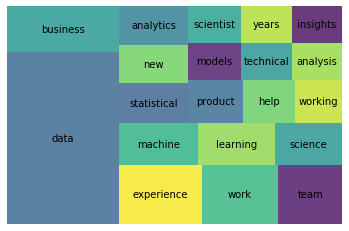

In [15]:
wc = count(indeed['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [16]:
##### Your Code Here #####
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

dtm = tfidf.fit_transform(data["description"])


dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())


dtm.head()

,00,000,02115,03,0356,04,062,06366,08,10,...,zenreach,zero,zeus,zf,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.104421,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [17]:
##### Your Code Here #####
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [23]:
nn.kneighbors(dtm)

(array([[0.        , 1.30072527, 1.30498405, 1.32151492, 1.32832696],
        [0.        , 1.27354692, 1.27538537, 1.2774335 , 1.27758136],
        [0.        , 1.25504835, 1.26982517, 1.27053449, 1.27445106],
        ...,
        [0.        , 0.        , 1.31487393, 1.31926402, 1.3213899 ],
        [0.        , 0.06613796, 1.20823303, 1.24366515, 1.24915813],
        [0.        , 1.2415786 , 1.26678126, 1.27180786, 1.2722277 ]]),
 array([[  0, 276, 336, 274, 338],
        [  1, 201, 351, 399,  59],
        [  2, 307, 318, 407, 250],
        ...,
        [ 44, 423,  16, 363, 383],
        [424, 382, 201, 383, 264],
        [425, 201, 264,  31, 307]]))

In [20]:
search = ["entry level data scientist for esports. create visuals and use machine learning tools such as scikit-leanrn"]
job_search = tfidf.transform(search)
job_search


<1x9816 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [21]:
nn.kneighbors(job_search.todense())

(array([[1.33887817, 1.33887817, 1.36007347, 1.36529703, 1.36529703]]),
 array([[184, 147, 336,  69, 402]]))

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 